In [1]:
import numpy as np
import pandas as pd
import TAF
import datetime
import talib 
import matplotlib.pylab as plt
import seaborn as sns
% matplotlib inline

In [2]:
factors = pd.read_csv('HS300_15m.csv')

index = factors['index']
High = factors.high.values
Low = factors.low.values
Close = factors.close.values
Open = factors.open.values
Volume = factors.volume.values

factors = TAF.get_factors(index, Open, Close, High, Low, Volume, drop=True)

factors = factors.iloc[-700 * 16 - 11 * 16:]

In [3]:
start_date = factors.index[11*16][:10]
end_date = factors.index[-1][:10]

print ('开始时间', start_date)
print ('结束时间', end_date)

开始时间 2014-02-25
结束时间 2016-12-30


In [4]:
rolling = 88

targets = pd.read_csv('HS300_1d.csv')
targets.rename(columns={'Unnamed: 0':'tradeDate'}, inplace=True)
targets['returns'] = targets.close.shift(-5)/ targets.close - 1.

targets.set_index('tradeDate', inplace=True)
targets= targets.loc[start_date:end_date, 'returns']

#### 输入数据

In [5]:
inputs = np.array(factors).reshape(-1, 1, 58)

targets = np.expand_dims(targets, axis=1)
targets = np.expand_dims(targets, axis=1)

train_inputs = inputs[:-100*16]
test_inputs = inputs[-100*16 - 11 * 16:]

train_targets = targets[:-100]
test_targets = targets[-100:]

train_gather_list = np.arange(train_inputs.shape[0])
train_gather_list = train_gather_list.reshape([-1,16])[11:]
train_gather_list = train_gather_list[:,-1]

test_gather_list = np.arange(test_inputs.shape[0])
test_gather_list = test_gather_list.reshape([-1,16])[11:]
test_gather_list = test_gather_list[:,-1]

#### DNCoreLSTM 回归测试

In [6]:
import tensorflow as tf
from DNCore import DNCoreLSTM

class Regression_DNCoreLSTM(object):
    
    def __init__(self, 
                 inputs, 
                 targets,
                 gather_list=None,
                 batch_size=1, 
                 hidden_size=50, 
                 memory_size=50, 
                 num_reads=3,
                 num_writes=1,  
                 learning_rate = 1e-4,
                 optimizer_epsilon = 1e-10,
                 max_gard_norm = 50,
                 reset_graph = True):
        
        if reset_graph:
            tf.reset_default_graph()
        # 控制参数
        self._tmp_inputs = inputs
        self._tmp_targets = targets
        self._in_length = None
        self._in_width = inputs.shape[2]
        self._out_length = None
        self._out_width = targets.shape[2]
        self._batch_size = batch_size

        # 声明会话
        self._sess = tf.InteractiveSession()
        
        self._inputs = tf.placeholder(
            dtype=tf.float32,
            shape=[self._in_length, self._batch_size, self._in_width],
            name='inputs')
        self._targets = tf.placeholder(
            dtype=tf.float32,
            shape=[self._out_length, self._batch_size, self._out_width],
            name='targets')
        
        self._RNNCoreCell = DNCoreLSTM(
            dnc_output_size=self._out_width, 
            hidden_size=hidden_size, 
            memory_size=memory_size, 
            word_size=self._in_width, 
            num_read_heads=num_reads,
            num_write_heads=num_writes)
        
        self._initial_state = \
        self._RNNCoreCell.initial_state(batch_size)
        
        output_sequences, _ = \
        tf.nn.dynamic_rnn(cell= self._RNNCoreCell, 
                          inputs=self._inputs, 
                          initial_state=self._initial_state, 
                          time_major=True)
        
        self._original_output_sequences = output_sequences
        if gather_list is not None:
            output_sequences = tf.gather(output_sequences, gather_list)
        output_sequences = tf.tanh(output_sequences) 
        
        cost = tf.square(output_sequences-self._targets)
        self._cost = tf.reduce_mean(cost)
        
        # Set up optimizer with global norm clipping.
        trainable_variables = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(self._cost, trainable_variables), max_gard_norm)
        global_step = tf.get_variable(
            name="global_step",
            shape=[],
            dtype=tf.int64,
            initializer=tf.zeros_initializer(),
            trainable=False,
            collections=[tf.GraphKeys.GLOBAL_VARIABLES, tf.GraphKeys.GLOBAL_STEP])
        
        optimizer = tf.train.RMSPropOptimizer(
            learning_rate=learning_rate, epsilon=optimizer_epsilon)
        self._train_step = optimizer.apply_gradients(
            zip(grads, trainable_variables), global_step=global_step)  
        
        self._sess.run(tf.global_variables_initializer())
        self._variables_saver = tf.train.Saver()
        
        
    def fit(self, 
            training_iters =1e2,             
            display_step = 5, 
            save_path = None,
            restore_path = None):
        
        if restore_path is not None:
            self._variables_saver.restore(self._sess, restore_path)
              
        for scope in range(np.int(training_iters)):
            self._sess.run([self._train_step],
                           feed_dict = {self._inputs:self._tmp_inputs, self._targets:self._tmp_targets})
            
            if scope % display_step == 0:
                loss = self._sess.run(
                    self._cost, 
                    feed_dict = {self._inputs:self._tmp_inputs, self._targets:self._tmp_targets})
                print (scope, '  loss--', loss)                    
                    
        print ("Optimization Finished!")         
        loss = self._sess.run(
            self._cost, feed_dict = {self._inputs:self._tmp_inputs, self._targets:self._tmp_targets})
        print ('Model assessment  loss--', '  loss--', loss)      
    
        # 保存模型可训练变量
        if save_path is not None:
            self._variables_saver.save(self._sess, save_path) 
            
    def close(self):
        self._sess.close()
        print ('结束进程，清理tensorflow内存/显存占用')
    
    def pred(self, inputs, gather_list=None, restore_path=None):
        output_sequences = self._original_output_sequences
        if gather_list is not None:
            output_sequences = tf.gather(output_sequences, gather_list)
        outputs = tf.tanh(output_sequences)
        return self._sess.run(outputs, feed_dict = {self._inputs:inputs})
    
    def restore_trainable_variables(self, restore_path):
        self._variables_saver.restore(self._sess, restore_path)

In [7]:
a = Regression_DNCoreLSTM(train_inputs, train_targets, train_gather_list)
a.fit(training_iters = 500, save_path='models/R1.ckpt')
a.close()

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0   loss-- 0.0149116
5   loss-- 0.0148272
10   loss-- 0.0147316
15   loss-- 0.0146004
20   loss-- 0.0144359
25   loss-- 0.0142147
30   loss-- 0.0139486
35   loss-- 0.0136023
40   loss-- 0.0131801
45   loss-- 0.0126733
50   loss-- 0.0120637
55   loss-- 0.0113554
60   loss-- 0.010562
65   loss-- 0.00970413
70   loss-- 0.00881338
75   loss-- 0.00794179
80   loss-- 0.00712633
85   loss-- 0.00642303
90   loss-- 0.0058539
95   loss-- 0.00543427
100   loss-- 0.00514201
105   loss-- 0.00493222
110   loss-- 0.00476724
115   loss-- 0.00462523
120   loss-- 0.00447889
125   loss-- 0.0043294
130   loss-- 0.00417228
135   loss-- 0.00400143
140   loss-- 0.00381986
145   loss-- 0.00363136
150   loss-- 0.00343413
155   loss-- 0.00324269
160   loss-- 0.00309782
165   loss-- 0.00289509
170   loss-- 0.00274539
175   loss-- 0.00262085
180   loss-- 0.00246892
185   loss-- 0.00235731
190   loss-- 0.00224838
195   loss-- 0.00213627
200   loss-- 0.00205065
205   loss-- 0.00195998
210   loss-- 0.00188252
215   

In [8]:
a = Regression_DNCoreLSTM(train_inputs, train_targets, train_gather_list)
a.fit(training_iters = 500, 
      save_path='models/R2.ckpt', 
      restore_path='models/R1.ckpt')
a.close()

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from models/R1.ckpt
0   loss-- 0.000584173
5   loss-- 0.000590047
10   loss-- 0.000567725
15   loss-- 0.00057557
20   loss-- 0.000555442
25   loss-- 0.000557696
30   loss-- 0.000540423
35   loss-- 0.000546677
40   loss-- 0.000524918
45   loss-- 0.000533925
50   loss-- 0.000510787
55   loss-- 0.000521456
60   loss-- 0.000498488
65   loss-- 0.000507708
70   loss-- 0.000486787
75   loss-- 0.000493403
80   loss-- 0.000476066
85   loss-- 0.000481163
90   loss-- 0.00046324
95   loss-- 0.000473
100   loss-- 0.000451606
105   loss-- 0.000459443
110   loss-- 0.000440397
115   loss-- 0.000451587
120   loss-- 0.000429613
125   loss-- 0.000439785
130   loss-- 0.000418625
135   loss-- 0.000430468
140   loss-- 0.000409455
145   loss-- 0.000418764
150   loss-- 0.00039949
155   loss-- 0.00041189
160   loss-- 0.000389385
165   loss-- 0.000401372
170   loss-- 0.000379985
175   loss-- 0.000394522
180   loss-- 0.000370459
185   loss-- 0.000385208
190   loss-- 0.0003592

In [9]:
a = Regression_DNCoreLSTM(train_inputs, train_targets, train_gather_list)
a.restore_trainable_variables(restore_path='models/R2.ckpt')
b = a.pred(train_inputs, train_gather_list)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from models/R2.ckpt


In [10]:
tmp = pd.DataFrame([train_targets.flatten(), b.flatten()]).T
tmp.columns = ['targets','dnc_tanh']

In [11]:
tmp.corr()

,targets,dnc_tanh
targets,1.000000,0.965116
dnc_tanh,0.965116,1.000000


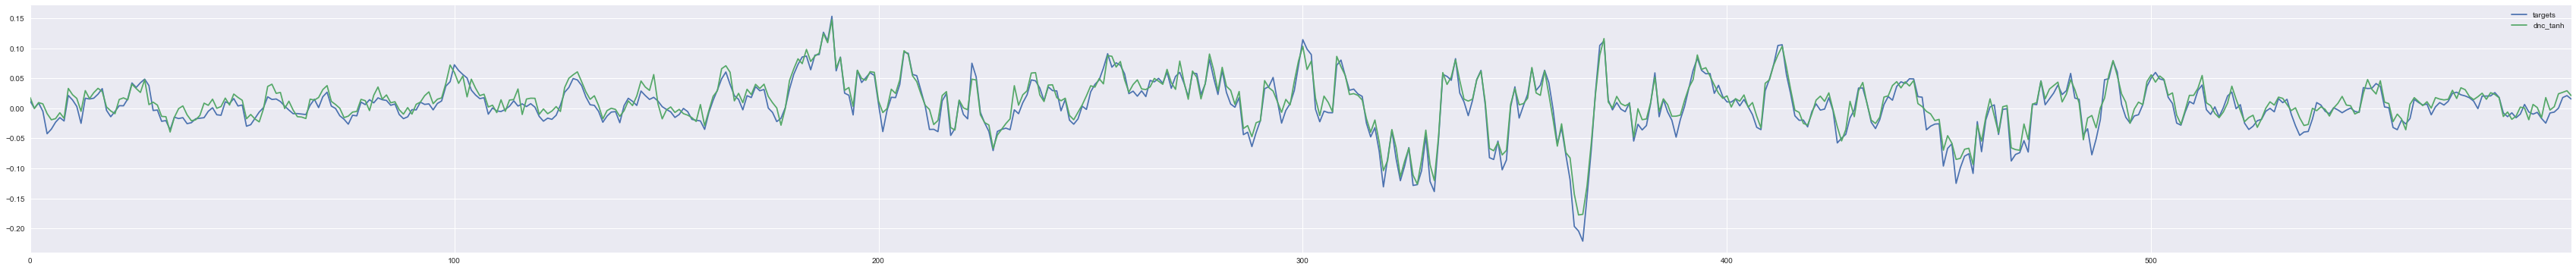

In [12]:
tmp.plot(figsize=(60,6))